### Import data

In [1472]:
import CSV
using LeastSquaresOptim, DifferentialEquations, DelayDiffEq, DiffEqBase, Optim, Plots, Statistics, DataFrames, JLD

# Import data
data = CSV.read("..//data//taxol1.csv")
total = CSV.read("..//data//taxol1_pop.csv")

# delete the extra index column which strats at 0 
delete!(data, :Column1)
delete!(total, :Column1)

# get the number of data points
len = length(data[:,1])
time = data[:,1]

# just to make sure all have the same size
total_old = total[:,9];
G2_old = data[:,9];

# rescaling the experimental data assuming we have 20 initial cells for each trial
init_cells = 20.0
total_new = init_cells * total_old
G2_new = 0.01*total_new.*G2_old;
G1_new = total_new .- G2_new;
g2_0 = init_cells*(G2_old[1]/100.0)
g1_0 = init_cells*(1- (G2_old[1]/100.0))

plot(G1_new, label = "G1")
plot!(G2_new, label = "G2")
plot!(total_new, label = "total")
print(g1_0, "\n", g2_0)

# param_holder_taxol1_dde = zeros(7,9);
# param_holder_taxol1_ode = zeros(4,9);

12.142176604
7.857823396000001

┌ Warning: `delete!(df::AbstractDataFrame, cols::Any)` is deprecated, use `deletecols!(df, cols)` instead.
│   caller = top-level scope at In[1472]:7
└ @ Core In[1472]:7
┌ Warning: `delete!(df::AbstractDataFrame, cols::Any)` is deprecated, use `deletecols!(df, cols)` instead.
│   caller = top-level scope at In[1472]:10
└ @ Core In[1472]:10


### ODE solve

In [1474]:
function ODEmodel(du, u, p, t)

    du[1] = -p[1]*u[1] + 2*p[2]*u[2] - p[3]*u[1]
    du[2] = p[1]*u[1] - p[2]*u[2] - p[4]*u[2]
end

function ODEsolve(par)
    t = LinRange(0.0, 95.5, 192)
    tspan = (0.0, 95.5)
    u0 = [g1_0, g2_0]
    prob = ODEProblem(ODEmodel, u0, tspan, par)
    solve(prob, Tsit5())
end

function residuals(par)
    t = LinRange(0.0, 95.5, 192)
    res = zeros(2, 192)
    sol = ODEsolve(par)
    res[2, :] = sol(t, idxs = 1).u - G1_new
    res[1, :] = sol(t, idxs = 2).u - G2_new
    return res
end

p = [10.0, 8.0, 0.8, 8.0]
t = LinRange(0.0, 95.5, 192)
low = [0.0, 0.0, 0.0, 0.0]

# result_ode = optimize(residuals, p, Dogleg(), lower = low)
result_ode = optimize(residuals, p, LevenbergMarquardt(), lower = low; iterations = 10^8)

Results of Optimization Algorithm
 * Algorithm: LevenbergMarquardt
 * Minimizer: [10.407053578132587,8.414318178369392,0.5271183196084762,7.642927236871003]
 * Sum of squares at Minimum: 732.953190
 * Iterations: 44
 * Convergence: true
 * |x - x'| < 1.0e-08: false
 * |f(x) - f(x')| / |f(x)| < 1.0e-08: true
 * |g(x)| < 1.0e-08: false
 * Function Calls: 45
 * Gradient Calls: 30
 * Multiplication Calls: 132


In [1514]:
params = result_ode.minimizer
param_holder_taxol1_ode[:, 9] = params
CSV.write("params_taxol1_ODE.csv", DataFrame(param_holder_taxol1_ode))

# param_holder_gem_dde = CSV.read("params_gem_DDE.csv")
# param_holder_gem_ode[:, 1] = ["alpha", "beta", "gamma1", "gamma2"]
# CSV.write("params_gem_ODE.csv", DataFrame(param_holder_gem_ode))

# params =  [0.129992538367695,0.04567232337751,0.017989068250636, 0.0601300854109052327189]

# sol = DDEsolve(params)
t = LinRange(0.0, 95.5, 192)

# plot(t, sol(t, idxs=2).u, label = "G1 est", legend =:topleft)
# plot!(t, G1_new, label = "G1")
# plot!(t, sol(t, idxs=1).u, title = "DOX Trial 2 DDE", label = "G2 est")
# plot!(t, G2_new, label = "G2")
# plot!(t, (sol(t, idxs=2).u + sol(t, idxs=1).u), label = "total est")
# plot!(t, total_new, label = "total")
# savefig("DOX_2_DDE.png")


t_new = LinRange(0.0, 195.5, 292)
tspan_new = (0.0, 195.5)
u0_new = [g1_0, g2_0]
prob_new = ODEProblem(ODEmodel, u0_new, tspan_new, params)
solution = solve(prob_new, Tsit5())

plot(t_new, solution(t_new, idxs=1).u, label = "G1 est", dpi = 150, xlabel = "time [hours]", ylabel = "# of cells")
plot!(t, G1_new, label = "G1", dpi = 150)
plot!(t_new, solution(t_new, idxs=2).u, label = "G2 est", title = "Tax. Trial 9 ODE", legend=:topright, dpi = 150)
plot!(t, G2_new, label = "G2", dpi = 150)
plot!(t_new, (solution(t_new, idxs=2).u + solution(t_new, idxs=1).u), label = "total est", dpi = 150)
plot!(t, total_new, label = "total", dpi = 150)
savefig("taxol1_9_ode_long.png")

### Using Dogleg()/ LevenbergMarquardt() for optimization DDE

In [1512]:
# This model doesn't assume delay for dying
function DDEmodel(du, u, h, p, t)
    du[1] = -p[1]*(h(p, t-p[3])[1]) + 2*p[2]*(h(p, t-p[4])[2]) - p[6]*u[1]
    du[2] = p[1]*(h(p, t-p[3])[1]) - p[2]*(h(p, t-p[4])[2]) - p[7]*u[2]
end

function DDEsolve(pp)
    lags = [pp[3], pp[4]]
    h(p, t) = pp[5]*ones(2)
    t = LinRange(0.0, 95.5, 192)

    tspan = (0.0, 95.5)
    u0 = [g1_0, g2_0]
    prob = DDEProblem(DDEmodel, u0, h, tspan, pp; constant_lags = lags)
    solve(prob)
end

function resid(pp)
    t = LinRange(0.0, 95.5, 192)
    res = zeros(2, 192)
    sol = DDEsolve(pp)
    res[1, :] = sol(t, idxs=1).u - G1_new
    res[2, :] = sol(t, idxs=2).u - G2_new
    return res
end

p = [10.407053578132587,8.414318178369392, 0.03165035986640648,33.50624238256753,12.617320332544436,0.5271183196084762,7.642927236871003]

low = [0.0001, 0.0001, 0.01, 0.01, 0.0001, 0.0001, 0.0001]
# results_dde = optimize(resid, p, Dogleg(), lower = low)
results_dde = optimize(resid, p, LevenbergMarquardt(), lower = low)

Results of Optimization Algorithm
 * Algorithm: LevenbergMarquardt
 * Minimizer: [10.407061371929725,8.4139923737069,0.03164826499776874,33.50660671354013,12.617380774194636,0.5270936317642616,7.643050416564164]
 * Sum of squares at Minimum: 48902.575018
 * Iterations: 10
 * Convergence: true
 * |x - x'| < 1.0e-08: true
 * |f(x) - f(x')| / |f(x)| < 1.0e-08: false
 * |g(x)| < 1.0e-08: false
 * Function Calls: 11
 * Gradient Calls: 3
 * Multiplication Calls: 30


### Solve and Plot for Dogleg() optimization

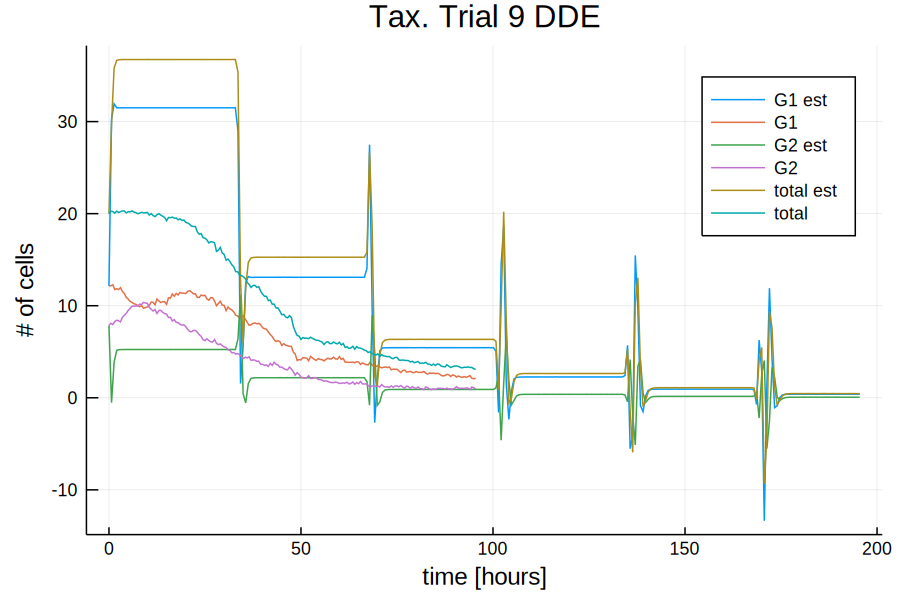

In [1523]:
# params = results_dde.minimizer
# param_holder_taxol1_dde[:, 9] = params 
# CSV.write("params_taxol1_DDE.csv",  DataFrame(param_holder_taxol1_dde))

# param_holder_gem_dde = CSV.read("params_gem_DDE.csv")
# param_holder_dox_dde[:, 1] = ["alpha", "beta", "tau1", "tau2", "history", "gamma1", "gamma2"]

# a function to find the percent of G2/G1
function g2Tog1(sol)
    t = LinRange(0.0, 95.5, 192)
    return (sol(t, idxs=2).u ./ sol(t, idxs=1).u) .*100
end

params =[1.407053578132587,2.414318178369392, 0.3165035986640648,33.50624238256753,12.617320332544436,0.5271183196084762,2.642927236871003]

# sol = DDEsolve(params)
t = LinRange(0.0, 95.5, 192)

# plot(t, sol(t, idxs=2).u, label = "G1 est", legend =:topleft)
# plot!(t, G1_new, label = "G1")
# plot!(t, sol(t, idxs=1).u, title = "DOX Trial 2 DDE", label = "G2 est")
# plot!(t, G2_new, label = "G2")
# plot!(t, (sol(t, idxs=2).u + sol(t, idxs=1).u), label = "total est")
# plot!(t, total_new, label = "total")
# savefig("DOX_2_DDE.png")

lags = [params[3], params[4]]
t_new = LinRange(0.0, 195.5, 292)
h(p, t_new) = params[5]*ones(2)
tspan_new = (0.0, 195.5)
u0_new = [g1_0, g2_0]
prob_new = DDEProblem(DDEmodel, u0_new, h, tspan_new, params; constant_lags = lags)
solution = solve(prob_new, MethodOfSteps(Tsit5()))

plot(t_new, solution(t_new, idxs=1).u, label = "G1 est", dpi = 150, xlabel = "time [hours]", ylabel = "# of cells")
plot!(t, G1_new, label = "G1", dpi = 150)
plot!(t_new, solution(t_new, idxs=2).u, label = "G2 est", title = "Tax. Trial 9 DDE", legend=:topright, dpi = 150)
plot!(t, G2_new, label = "G2", dpi = 150)
plot!(t_new, (solution(t_new, idxs=2).u + solution(t_new, idxs=1).u), label = "total est", dpi = 150)
plot!(t, total_new, label = "total", dpi = 150)
# savefig("taxol1_9_dde_long.png")